# Tree Based Implementation for GRP Estimation
## Includes data import and feature engineering

## Import required libraries

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
import calendar

## Loading datasets month wise

In [164]:
Jan = pd.read_excel('../Data/January.xlsx')  
Feb = pd.read_excel('../Data/February.xlsx')  
Mar = pd.read_excel('../Data/March.xlsx')
Apr = pd.read_excel('../Data/April.xlsx')
May = pd.read_excel('../Data/May.xlsx')
Jun = pd.read_excel('../Data/June.xlsx')
Jul = pd.read_excel('../Data/July.xlsx')
Aug = pd.read_excel('../Data/August.xlsx')
Sept1 = pd.read_excel('../Data/September1.xlsx')
Sept2 = pd.read_excel('../Data/September2.xlsx')
Sept3 = pd.read_excel('../Data/September3.xlsx')
Sept = Sept1.append(Sept2, ignore_index=True).append(Sept3,ignore_index = True)
Oct = pd.read_excel('../Data/October.xlsx')
Nov = pd.read_excel('../Data/November.xlsx')
Dec1 = pd.read_excel('../Data/December1.xlsx')
Dec2 = pd.read_excel('../Data/December2.xlsx')
Dec = Dec1.append(Dec2, ignore_index=True)

## Data Cleaning

In [165]:
# Adding a month feature in all tables

Jan['Month'] = 'January'
Feb['Month'] = 'February'
Mar['Month'] = 'March'
Apr['Month'] = 'April'
May['Month'] = 'May'
Jun['Month'] = 'June'
Jul['Month'] = 'July'
Aug['Month'] = 'August'
Sept['Month'] = 'September'
Oct['Month'] = 'October'
Nov['Month'] = 'November'
Dec['Month'] = 'December'

# Changing column names

col_names = ['Media','Estimate','Access','DMA','Market','StationId','Length','Date','Time','Spot_Cost','Spot_Type','GRP','IMP','Month']

Jan.columns = col_names
Feb.columns = col_names
Mar.columns = col_names
Apr.columns = col_names
May.columns = col_names
Jun.columns = col_names
Jul.columns = col_names
Aug.columns = col_names
Sept.columns = col_names
Oct.columns = col_names
Nov.columns = col_names
Dec.columns = col_names

# Joining all tables

dat = Jan.append(Feb, ignore_index=True).append(Mar, ignore_index=True).append(Apr, ignore_index=True).append(May, ignore_index=True).append(Jun, ignore_index=True).append(Jul, ignore_index=True).append(Aug, ignore_index=True).append(Sept, ignore_index=True).append(Oct, ignore_index=True).append(Nov, ignore_index=True).append(Dec, ignore_index=True)
dat.head()


# Changing data types

dtypes = {
    "Media": str,
    "Estimate": str,
    "Access": str,
    "DMA": str,
    "Market": str,
    "StationId": str,
    "Length": int,
    "Date": str,
    "Time": str,
    "Spot_Cost": float,
    "Spot_Type": str,
    "GRP": float,
    "IMP": float,
    "Month": str,
}

dat = dat.astype(dtypes)

## Feature Engineering

In [166]:
dat["Date"] = pd.to_datetime(dat["Date"], format="%Y-%m-%d")
dat["Day_Of_Week"] = dat["Date"].dt.day_name()
dat["Hour_Slot"] = dat.loc[:,'Time'].apply(lambda x: (x[:2]))
dat["Access"] = dat.loc[:,'Access'].apply(lambda x: (x[2:]))

### Dealing with Station Outliers

In [167]:

# We use the outlier list to identify the outliers and rank the outliers in terms of their outlierness 
Outlier_List = ['216','184','200','311','352','10','192','15','280','252','224','350','55','95','72','28','230','140','57','345']
dat['Outlier'] = dat.StationId.apply(lambda x: 'yes' if x in Outlier_List else 'no')
dat['Outlier_Level'] = dat.Outlier.apply(lambda x: '0' if x == 'no' else '1')
dat.loc[dat['Outlier_Level'] == '1','Outlier_Level'] = pd.cut(dat[dat.Outlier == 'yes']['IMP'],5, labels=["1", "2", "3",'4','5'])


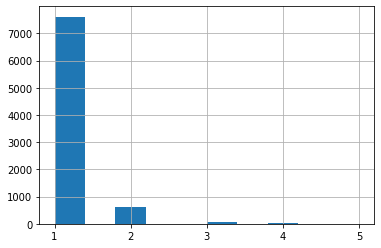

In [168]:

# Distribution of the Outlier_Level in the dataset
pd.cut(dat[dat.Outlier == 'yes']['IMP'],5, labels=["1", "2", "3",'4','5']).hist()


## Joining Station Universe data

In [169]:
station_universe = pd.read_excel('/home/jovyan/Desktop/Direct_Avenue_GRP_Project/Data/station universe.xlsx') 
station_universe.columns = ['StationId','Station_Category','Station_Size']
dtypes = {
    "StationId" : str,
    "Station_Category" : str,
    "Station_Size" : float
}

station_universe = station_universe.astype(dtypes)
dat = pd.merge(dat,station_universe, on = ['StationId'], how = 'left')

In [170]:
# Create new audience size column
dat['Audience_Size'] = dat['GRP']*dat['Station_Size']

# Remove null values caused by left join
dat = dat.dropna()

## Feature Selection and Split

In [171]:
req = ['Estimate','Market','StationId','Length','Spot_Cost','Day_Of_Week','Hour_Slot','Outlier_Level','Audience_Size']
d1 = dat.loc[:,req]

In [172]:
d1.head()

,Estimate,Market,StationId,Length,Spot_Cost,Day_Of_Week,Hour_Slot,Outlier_Level,Audience_Size
0,Q119,National Network,37,30,56.0,Monday,00,0,0.000
1,Q119,Cable,202,30,56.0,Monday,00,0,0.000
2,Q119,Cable,253,30,142.4,Monday,00,0,0.656
3,Q119,Cable,340,30,64.0,Monday,00,0,7.680
4,Q119,Cable,168,30,56.0,Monday,00,0,0.000


In [173]:
# Convert to one hot encoding
d2 = pd.get_dummies(d1)

# split data into rated and unrated
rated = d2.loc[d2.Audience_Size != 0]
unrated = d2.loc[d2.Audience_Size == 0]

#Get test data to predict Audience size ...unrated
test_data = unrated.drop(['Audience_Size'], axis = 1)

In [174]:
# Use rated data to split into train and validation
label = rated['Audience_Size']
features = rated.drop(['Audience_Size'], axis = 1)

from sklearn.model_selection import train_test_split  

X_train, X_valid, y_train, y_valid = train_test_split(features,label,test_size = 0.3,random_state = 1234)  

print("Training set has {} samples.".format(X_train.shape[0])) 
print("Validation set has {} samples.".format(X_valid.shape[0]))

Training set has 39601 samples.
Validation set has 16973 samples.


## Gradient Boosting Regressor Implementation (NO TUNING)

In [175]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Fit regression model

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
    
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
rmse = mean_squared_error(y_valid, clf.predict(X_valid),squared=False)
print("RMSE: %.4f" % rmse)


RMSE: 1.3694


Text(0, 0.5, 'Deviance')

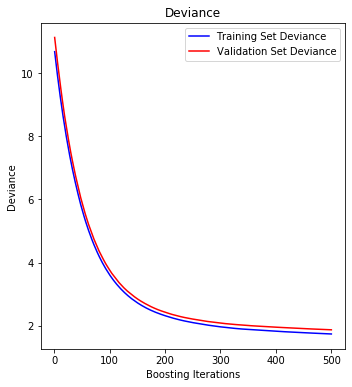

In [176]:
# Plot training deviance

# compute test set deviance
valid_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_valid)):
    valid_score[i] = clf.loss_(y_valid, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, valid_score, 'r-',
         label='Validation Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

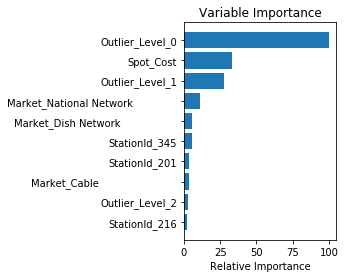

In [177]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-10:]
pos = (np.arange(sorted_idx.shape[0]) + .5)[-10:]
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## XGBoost Regressor ( Hyper paramter tuning )

In [138]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [5,10,20],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [ 300, 500]
}
# Create a based model
clf_base = XGBRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf_base, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2,scoring = 'neg_root_mean_squared_error')

In [110]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 105.5min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 111.0min finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:24:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 500}

In [178]:
best_grid = grid_search.best_estimator_
rmse = mean_squared_error(y_valid, best_grid.predict(X_valid),squared=False)
print("RMSE: %.4f" % rmse)
clf = best_grid

RMSE: 1.1702


In [179]:
best_grid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, max_features=5, min_child_weight=1,
             min_samples_leaf=3, min_samples_split=8, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

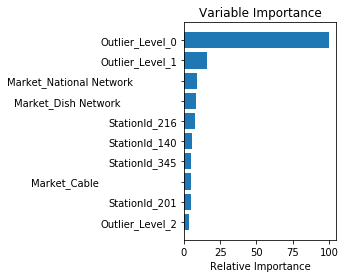

In [180]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-10:]
pos = (np.arange(sorted_idx.shape[0]) + .5)[-10:]
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

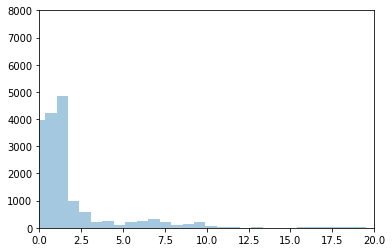

In [181]:
fig, ax = plt.subplots()
sns.distplot(best_grid.predict(X_valid),bins=80, kde=False,ax=ax)
ax.set_xlim(0,20)
ax.set_ylim(0,8000)
#ax.set_xticks(range(0,400,100))
plt.show()


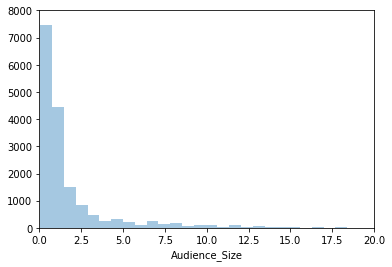

In [182]:
fig, ax = plt.subplots()
sns.distplot(y_valid, kde=False,bins=80,ax=ax)
ax.set_xlim(0,20)
ax.set_ylim(0,8000)
#ax.set_xticks(range(0,400,100))
plt.show()



## Random Forest ( Hyperparameter Tuning )

In [132]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10],
    'max_features': [5,10 ],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8],
    'n_estimators': [300]
}
# Create a based model
clf_base = RandomForestRegressor()
# Instantiate the grid search model
grid_searchrf = GridSearchCV(estimator = clf_base, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'neg_root_mean_squared_error')

In [133]:
# Fit the grid search to the data
grid_searchrf.fit(X_train, y_train)
grid_searchrf.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   51.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   51.2s finished


{'max_depth': 10,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [134]:
best_gridrf = grid_searchrf.best_estimator_
best_gridrf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=10, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [135]:
rmse = mean_squared_error(y_valid, best_gridrf.predict(X_valid),squared=False)
print("RMSE: %.4f" % rmse)
clfrf = best_gridrf

RMSE: 2.2309


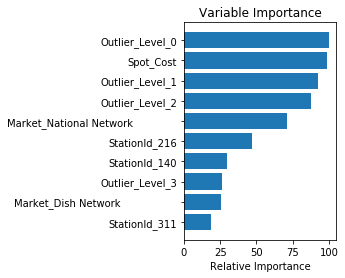

In [136]:
# Plot feature importance
feature_importance = clfrf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-10:]
pos = (np.arange(sorted_idx.shape[0]) + .5)[-10:]
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Predict on Unrated Spots 

Clearly the best model obtained is the tuned XGboost model from XGBRegressor() with the lowest RMSE of 1.17 on the validation set. This model is used to predict on the unrated data, ie, where the audience size is zero.

In [188]:
# Export the best model using joblib

import joblib

model = best_grid
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(model, '../' + filename)

# FOLLOW THE CODE BELOW TO LOAD SAVED MODEL
# loaded_model = joblib.load(filename)

['../finalized_model.sav']

In [189]:
unrated = dat.loc[dat.Audience_Size == 0]
unrated['Estimated_Audience_Size'] = model.predict(test_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [190]:
unrated.head()

,Media,Estimate,Access,DMA,Market,StationId,Length,Date,Time,Spot_Cost,...,IMP,Month,Day_Of_Week,Hour_Slot,Outlier,Outlier_Level,Station_Category,Station_Size,Audience_Size,Estimated_Audience_Size
0,TV,Q119,GD,900,National Network,37,30,2018-12-31,00:06:00,56.0,...,0.0,January,Monday,00,no,0,News,41.0,0.0,4.059373
1,TV,Q119,TN,900,Cable,202,30,2018-12-31,00:07:00,56.0,...,0.0,January,Monday,00,no,0,Variety,30.0,0.0,1.087565
4,TV,Q119,GD,900,Cable,168,30,2018-12-31,00:10:00,56.0,...,0.0,January,Monday,00,no,0,Lifestyle,12.5,0.0,1.087565
5,TV,Q119,GD,900,Cable,305,30,2018-12-31,00:16:00,268.8,...,0.0,January,Monday,00,no,0,Sports,38.0,0.0,2.500762
6,TV,Q119,GD,900,Cable,372,30,2018-12-31,00:17:00,80.0,...,0.0,January,Monday,00,no,0,News,50.0,0.0,1.176099


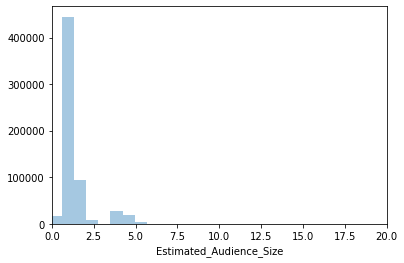

In [191]:
# Plot the distribution of predicted audience size on the unrated data

fig, ax = plt.subplots()
sns.distplot(unrated['Estimated_Audience_Size'], kde=False,bins=80,ax=ax)
ax.set_xlim(0,20)
#ax.set_ylim(0,1000)
#ax.set_xticks(range(0,400,100))
plt.show()


## GRP and REACH Estimation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


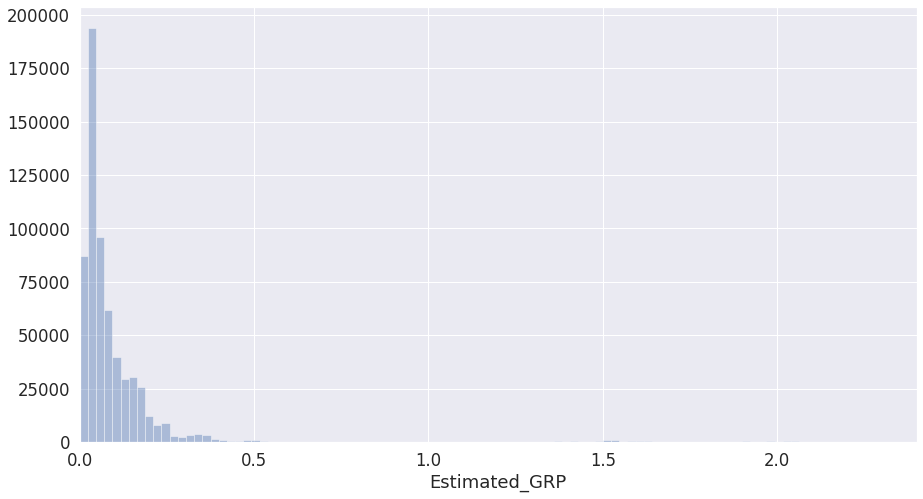

In [211]:

# Estimate Ratings/GRP

unrated['Estimated_GRP'] = unrated['Estimated_Audience_Size'] / unrated['Station_Size']
unrated.loc[unrated['Estimated_GRP'] < 0,'Estimated_GRP'] = 0

# Plot the distribution of predicted audience size on the unrated data
sns.set(style='darkgrid')

plt.rcParams["figure.figsize"] = [15,8]
sns.set(font_scale=1.5)
xhigh = 2.4
plt.xlim(0,xhigh)
temp = unrated[(unrated['Estimated_GRP'] <= xhigh) ]
sns.distplot(temp['Estimated_GRP'], kde=False,bins=100)
plt.show()

In [216]:
print('The mean GRP Estimated is:')
np.mean(unrated['Estimated_GRP'])

The mean GRP Estimated is:


0.10780117859079634

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


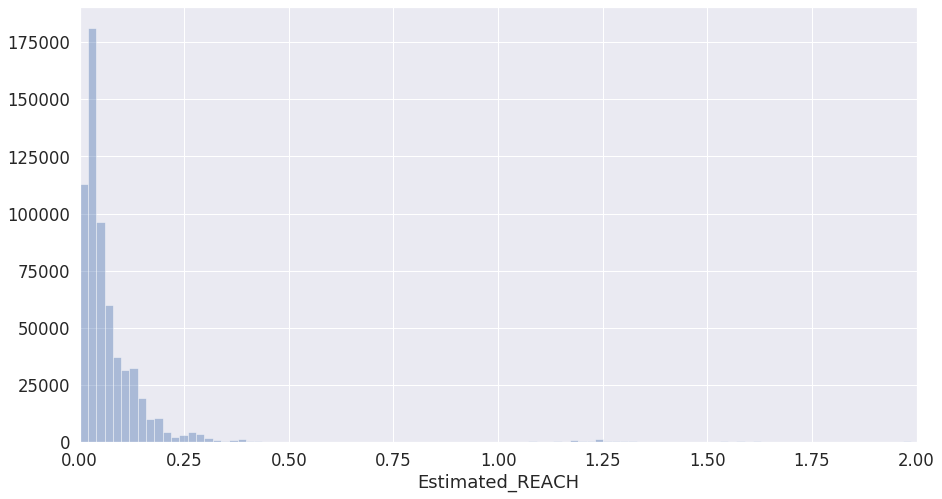

In [219]:

# Estimate REACH
# We select frequecy metric = 1.25 as a reasonable approximation to get REACH 

unrated['Estimated_REACH'] = (unrated['Estimated_GRP'] / 1.25) 

# Plot the distribution of predicted audience size on the unrated data
sns.set(style='darkgrid')

plt.rcParams["figure.figsize"] = [15,8]
sns.set(font_scale=1.5)
xhigh = 2
plt.xlim(0,xhigh)
temp = unrated[(unrated['Estimated_REACH'] <= xhigh) ]
sns.distplot(temp['Estimated_REACH'], kde=False,bins=100)
plt.show()

In [220]:
print('The mean REACH Estimated is:')
np.mean(unrated['Estimated_REACH'])

The mean REACH Estimated is:


0.08624094287263706

In [221]:
unrated.head()

,Media,Estimate,Access,DMA,Market,StationId,Length,Date,Time,Spot_Cost,...,Day_Of_Week,Hour_Slot,Outlier,Outlier_Level,Station_Category,Station_Size,Audience_Size,Estimated_Audience_Size,Estimated_GRP,Estimated_REACH
0,TV,Q119,GD,900,National Network,37,30,2018-12-31,00:06:00,56.0,...,Monday,00,no,0,News,41.0,0.0,4.059373,0.099009,0.079207
1,TV,Q119,TN,900,Cable,202,30,2018-12-31,00:07:00,56.0,...,Monday,00,no,0,Variety,30.0,0.0,1.087565,0.036252,0.029002
4,TV,Q119,GD,900,Cable,168,30,2018-12-31,00:10:00,56.0,...,Monday,00,no,0,Lifestyle,12.5,0.0,1.087565,0.087005,0.069604
5,TV,Q119,GD,900,Cable,305,30,2018-12-31,00:16:00,268.8,...,Monday,00,no,0,Sports,38.0,0.0,2.500762,0.065810,0.052648
6,TV,Q119,GD,900,Cable,372,30,2018-12-31,00:17:00,80.0,...,Monday,00,no,0,News,50.0,0.0,1.176099,0.023522,0.018818


## Export Final UNRATED DATA

In [222]:
# Export the unrated data with Audience Size predictions, GRP and REACH to csv

unrated.to_csv('../Unrated_Estimates.csv')